# Q8 Analyze HRV

Dig into the Rhinovirus results in the Q8 sequencing run.

In prior RespiCoV analyses I've relied on hits caching to enable fast analysis. But in Q8 I have a ton more data (28 Gb uncompressed, 22M reads) using a variety of different primers, as well as a lot of samples using only Rhinovirus primers. So rather than use hits caching, let's just split out the entire set of Rhinovirus hits and operate on that. 

This looks over all Q8a/b sequencing reads for the HRV 5' UTR region targetted by the RespiCoV Enterovirus primer pair. Most experiments actually used the HRVKa5 primer set, but they different from ENT rc only in the reverse primer extending 2 bases further beyond the amplicon, so we can just ignore that.

Note that these samples also include a full-genome HRV sequence which we want to exclude.
Reads were basecalled and demuxed with Dorado 0.7.3, using the hac@v5.0.0 model and with barcodes and adapters trimmed.
Reads have not yet been filtered for quality, we do that here.

## Setup

In [1]:
from Bio import Align
import matplotlib_inline.backend_inline
import os
import pandas as pd
import RCUtils
import random
import numpy as np
import Bio

%load_ext autoreload
%autoreload 1
%aimport RCUtils

# Be deterministic
random.seed(42)

fastQDir = "../Q8/reads-hac/"
hrvDir = "../Q8/reads-hac-hrv/"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

print("BioPython version:", Bio.__version__)

# Get the Rhinovirus primer pair.
rcPrimers = RCUtils.readPrimers("RespiCovPrimers.fasta")
hrvPrimers = [p for p in rcPrimers if p.description == "Rhinovirus/Enterovirus 1" or p.description == "Rhinovirus/Enterovirus 3"]
print("Rhinovirus primers:", [str(p.seq) for p in hrvPrimers])


BioPython version: 1.80
Rhinovirus primers: ['CAAGCACTTCTGTTTCCCCGG', 'AACACGGACACCCAAAGTAGT']


## Utilities

In [17]:
import math

# Get the hits across all files but allow a limit on the number of reads per file.
# Many files have over a million reads.
def getAllPrimerHits(maxReadsPerFile = 0, progress = False, skipReads = 0):
    for file in sorted(filter(lambda f: f.endswith(".fastq"), os.listdir(fastQDir))):
        for (read, hit) in getPrimerHits(file, maxReadsPerFile, progress, skipReads):
            yield (file, read, hit)

# Get primer hits for a single file
def getPrimerHits(file, maxReadsPerFile = 0, progress = False, skipReads = 0, matchThreshold = RCUtils.MATCH_THRESHOLD):
    fastQPath = os.path.join(fastQDir, file)
    if progress:
        print("Processing ", os.path.basename(fastQPath), end="")
    reads = 0
    hitReads = 0
    for read in RCUtils.readFastQ(fastQPath):
        reads += 1
        if reads <= skipReads:
            continue
        hits = RCUtils.computePrimerHits(read, hrvPrimers, matchThreshold=matchThreshold)
        if hits:
            hitReads += 1
            yield (read, hits)
        if maxReadsPerFile and reads >= skipReads + maxReadsPerFile:
            break
    if progress:
        totalReads = max(reads - skipReads, 0)
        print(" %d reads, %d with hits (%d%%)" % (totalReads, hitReads, hitReads * 100 / totalReads if totalReads else 0))

# Compute an overall probability of error as a phred score
# This tends to higly penalize a single error, so may not be as useful as the mean phred score
def overallPhredScore(phred_scores):
    # Phred scores represent the probability of error, eg. with 10 being 1 in 10, 20 being 1 in 100, etc.
    total_error_prob = 1 - math.prod(1 - 10 ** (-q / 10) for q in phred_scores)
    if total_error_prob == 0:
        return float('inf')
    return -10 * math.log10(total_error_prob)

# Print an alignment with an additional track indicating the quality scores of the read
def printAlignmentWithQuality(alignment, read):
    assert(alignment.target is read.seq)
    quality_scores = read.letter_annotations["phred_quality"]
    
    # Initialize strings for the aligned target, query, alignment string, and query quality scores
    aligned_target = ""
    aligned_query = ""
    alignment_string = ""
    aligned_target_quality = ""
    
    # Use indices to determine where gaps are and construct the alignment, target, query, and quality strings

    for t_index, q_index in zip(*alignment.indices):
        aligned_target += alignment.target[t_index] if t_index != -1 else "-"
        aligned_query += alignment.query[q_index] if q_index != -1 else "-"
        alignment_string += "|" if t_index != -1 and q_index != -1 and alignment.target[t_index] == alignment.query[q_index] else "."
        if t_index == -1:
            aligned_target_quality += "-"
        else:
            ns = quality_scores[t_index] // 4
            aligned_target_quality += str(ns) if ns < 10 else "9"

    tstart = alignment.indices[0,0]
    tend = alignment.indices[0,-1]
    print("target quality     ", aligned_target_quality, "  avg:", int(np.mean(quality_scores[tstart:tend])))
    print("target             ", aligned_target)
    print("                   ", alignment_string)
    print("query              ", aligned_query)
    print("")

# Print the hits for a read
def printHits(read, hits):
    print ("%s %d" % (read.id, len(read)))
    for hit in hits:
        print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))
        aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
        alignment = aligner.align(read.seq, hit.primer.rcSeq if hit.rev else hit.primer.seq)[0]
        RCUtils.extendAlignment(alignment)
        printAlignmentWithQuality(alignment, read)

## Get an idea for the distribution of reads with hits

Barcodes 1 to 7 are our main HRV samples and as expected have the bulk of the hits.
Barcodes 19-21 are RespiCoV and so are expected to have some HRV.
Barcode 18 is the HRV-C1 full genome. Why don't we see hits here? Shouldn't I have to filter out these ~1200bp HRV hits?
A few of the other hits occur in samples using other RespiCov primers but not HRV, why?

In [18]:
hitCount = 0
for (inFile, read, hits) in getAllPrimerHits(maxReadsPerFile=1000, progress=True):
    hitCount += len(hits)

print("Total hits:", hitCount)

Processing  Q8-hac_barcode01.fastq 1000 reads, 946 with hits (94%)
Processing  Q8-hac_barcode02.fastq 1000 reads, 888 with hits (88%)
Processing  Q8-hac_barcode03.fastq 1000 reads, 947 with hits (94%)
Processing  Q8-hac_barcode04.fastq 1000 reads, 875 with hits (87%)
Processing  Q8-hac_barcode05.fastq 1000 reads, 918 with hits (91%)
Processing  Q8-hac_barcode06.fastq 1000 reads, 916 with hits (91%)
Processing  Q8-hac_barcode07.fastq 1000 reads, 970 with hits (97%)
Processing  Q8-hac_barcode08.fastq 1000 reads, 0 with hits (0%)
Processing  Q8-hac_barcode09.fastq 1000 reads, 0 with hits (0%)
Processing  Q8-hac_barcode10.fastq 1000 reads, 0 with hits (0%)
Processing  Q8-hac_barcode11.fastq 1000 reads, 9 with hits (0%)
Processing  Q8-hac_barcode12.fastq 1000 reads, 383 with hits (38%)
Processing  Q8-hac_barcode13.fastq 1000 reads, 5 with hits (0%)
Processing  Q8-hac_barcode14.fastq 1000 reads, 121 with hits (12%)
Processing  Q8-hac_barcode15.fastq 1000 reads, 1 with hits (0%)
Processing  Q

## Look at the first few hits in detail just to sanity check

These look good. Primer pair hits at the exact start and end of the trimmed read.
Mismatches seem to be in areas of low basecall quality.

In [4]:
from Bio import Align

for (read, hits) in getPrimerHits("Q8-hac_barcode01.fastq.gz", maxReadsPerFile=5):
    printHits(read, hits)


bbe4b3b4-92cc-4ded-8674-52697668e304 387
   0.95 0-22: Rhinovirus/Enterovirus 3 (21)
target quality      7766666667777788882112   avg: 26
target              AACACGGACACCCAAAGTCAGT
                    ||||||||||||||||||.|||
query               AACACGGACACCCAAAGT-AGT

   0.90 368-387: Rhinovirus/Enterovirus 1 (21 rev)
target quality      6656676777778866666--   avg: 27
target              CCGGGGAAACAGAAGTGCT--
                    |||||||||||||||||||..
query               CCGGGGAAACAGAAGTGCTTG

21b616e1-0b07-4359-bbe1-b46ea58bbffa 389
   1.00 0-21: Rhinovirus/Enterovirus 3 (21)
target quality      667444467888899998776   avg: 29
target              AACACGGACACCCAAAGTAGT
                    |||||||||||||||||||||
query               AACACGGACACCCAAAGTAGT

   1.00 367-388: Rhinovirus/Enterovirus 1 (21 rev)
target quality      888778899988998555999   avg: 33
target              CCGGGGAAACAGAAGTGCTTG
                    |||||||||||||||||||||
query               CCGGGGAAACAGAAGTGCTTG

6a4010fc

## Match score distributions

We're using a default match threshold of 0.8. Make sure that still looks reasonable by comparing the distribution beyond that.
This looks only at the start of one barcode group, it will vary later in the read sequence. This (along with the examples above) also confirms that we'd be throwing away a lot of good matches if we required an exact match.

9358 of 19726 (47%) of primer hits are a perfect match


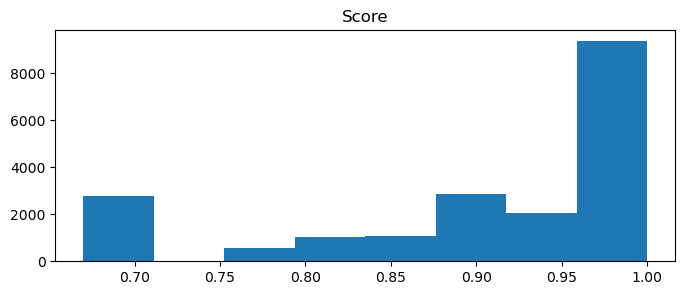

In [5]:
mrs = []
perfect = 0
for (read, hits) in getPrimerHits("Q8-hac_barcode01.fastq.gz", maxReadsPerFile=10000, matchThreshold = 0.65):
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=8, grid=False);

## Distribution of read lengths with hits.

HRV amplicons are expected to be about 390 bp, and indeed the vast majority are.

Reads with at least 2 hits: 6850, length 340-440: 6760 (98%)


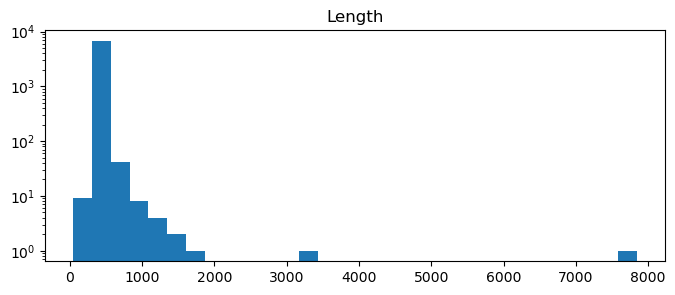

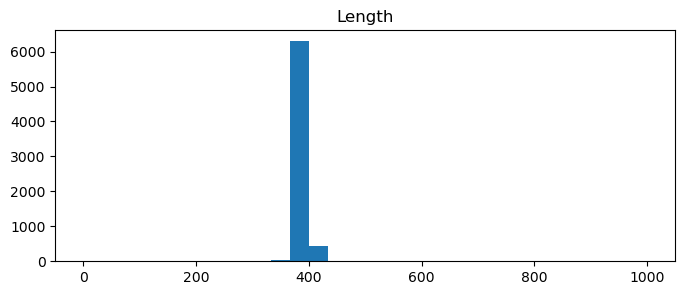

In [6]:
import matplotlib.pyplot as plt

EXPECTED_LENGTH = 390
LENGTH_TOLERANCE = 50

def plotLengths(fastq):
    lens = []
    reads = 0
    within50 = 0
    for (read, hits) in getPrimerHits(fastq, maxReadsPerFile=10000):
        if len(hits) < 2:
            continue
        reads += 1
        if abs(len(read) - EXPECTED_LENGTH) < LENGTH_TOLERANCE:
            within50 += 1
        lens.append(len(read))

    print("Reads with at least 2 hits: %d, length 340-440: %d (%d%%)" % (reads, within50, 100*within50/reads))

    pd.DataFrame({'Length': lens}).hist(figsize=(8,3), bins=30, grid=False, log=True)
    plt.show()

    pd.DataFrame({'Length': lens}).hist(figsize=(8,3), bins=30, grid=False, range=(0, 1000))
    plt.show()

plotLengths("Q8-hac_barcode01.fastq.gz")

Check one of the mess full RespiCoV samples too. It's quite different, but that's probably due to primer-dimers and other artifacts. 

Reads with at least 2 hits: 109, length 340-440: 6 (5%)


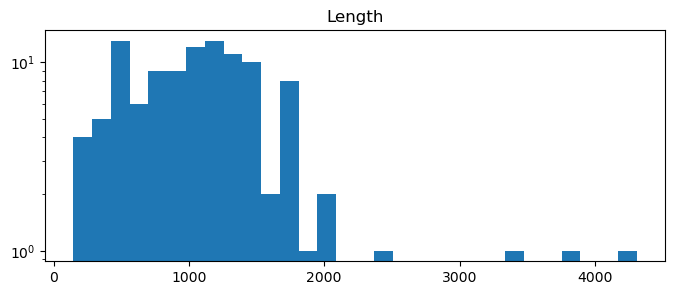

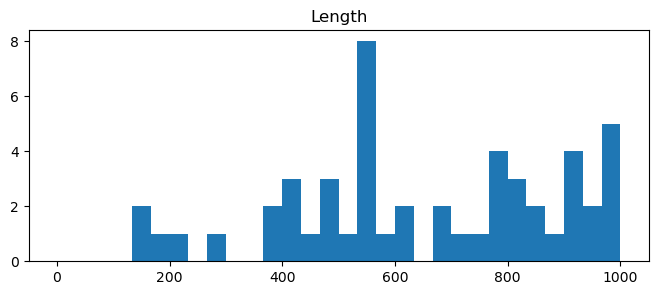

In [7]:
plotLengths("Q8-hac_barcode20.fastq.gz")

## Distribution of hit locations

Perhaps we could make things a lot faster by looking only at the start and end of the read for hits? With dorado having done read splitting and adapter trimming for us, perhaps all legit primers will really be at the start and end of reads?

Hits: 13524, exact: 6842 (50%), within 10: 13423 (99%)


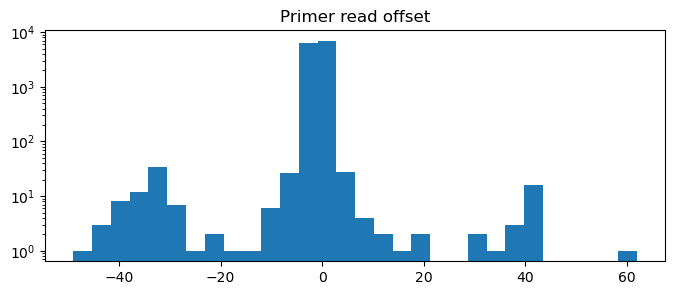

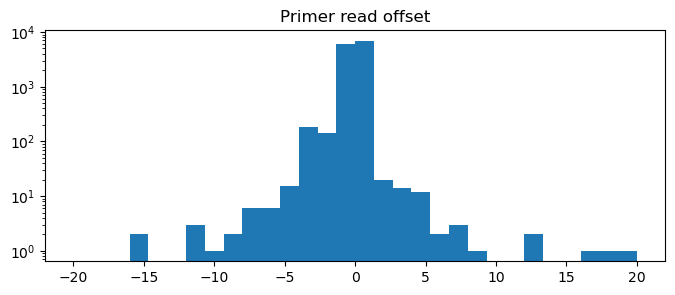

In [8]:
MAX_PRIMER_OFFSET = 10

def plotHitOffsets(fastq):
    offsets = []
    hitCount = 0
    exactHit = 0
    within10 = 0
    for (read, hits) in getPrimerHits(fastq, maxReadsPerFile=10000):
        if len(hits) < 2:
            continue
        if abs(len(read) - EXPECTED_LENGTH) > LENGTH_TOLERANCE:
            continue
        for hit in hits:
            hitCount += 1
            so = hit.start
            eo = len(read) - hit.end
            if min(so, eo) == 0:
                exactHit += 1
            if min(so, eo) <= MAX_PRIMER_OFFSET:
                within10 += 1
            if (so < eo):
                offsets.append(so)
            else:
                offsets.append(-eo)

    print("Hits: %d, exact: %d (%d%%), within 10: %d (%d%%)" % (hitCount, exactHit, 100*exactHit/hitCount, within10, 100*within10/hitCount))
    df = pd.DataFrame({'Primer read offset': offsets})
    ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True)
    plt.show()

    ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True, range=(-20,20))
    plt.show()

plotHitOffsets("Q8-hac_barcode01.fastq.gz")

And again on RespiCov

Hits: 12, exact: 6 (50%), within 10: 9 (75%)


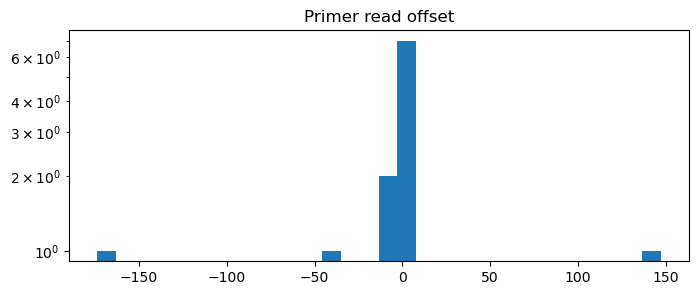

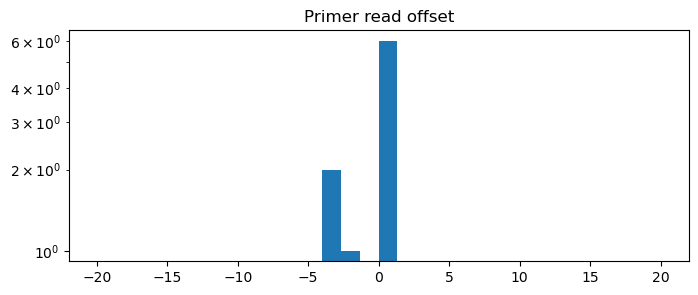

In [9]:
plotHitOffsets("Q8-hac_barcode20.fastq.gz")

## Distribution of read qualities

We need a threshold for filtering out low-quality reads. Let's take a look at a sample distribution.

Reads: 6762, qual p5: 13, qual reads: 6650 (98%)


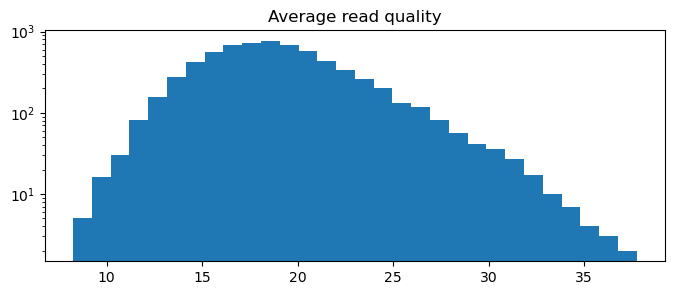

In [10]:
avgQuals = []
reads = 0
qualReads = 0
MIN_QUAL = 12

for (read, hits) in getPrimerHits("Q8-hac_barcode01.fastq.gz", maxReadsPerFile=10000):
    if len(hits) < 2:
        continue
    if abs(len(read) - EXPECTED_LENGTH) > LENGTH_TOLERANCE:
        continue
    reads += 1
    aq = np.mean(read.letter_annotations["phred_quality"])
    avgQuals.append(aq)
    if (aq >= MIN_QUAL):
        qualReads += 1

print ("Reads: %d, qual p5: %d, qual reads: %d (%d%%)" % (reads, np.percentile(avgQuals, 5), qualReads, 100*qualReads/reads))
df = pd.DataFrame({'Average read quality': avgQuals})
ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True)
plt.show()


# Make cached HRV read files with optimized hit finding

Based on the above we can search just for primers at the start and end of reads between 340 and 440 bases long, and with reads of at least Q12, and save them to their own files.

In [11]:
import gzip
from Bio import SeqIO
import time

scanLen = max([len(p.seq) for p in hrvPrimers]) + MAX_PRIMER_OFFSET

for inFile in sorted(filter(lambda f: f.endswith(".fastq.gz"), os.listdir(fastQDir))):
    hrvFile = os.path.join(hrvDir, "HRV-" + inFile)
    if os.path.exists(hrvFile):
        print("Skipping existing file:", hrvFile)
        continue
    
    with gzip.open(hrvFile, "wt") as out:
        inPath = os.path.join(fastQDir, inFile)
        print("Processing", os.path.basename(inPath), end="")
        reads = 0
        hitReads = 0
        start = time.process_time()
        for read in RCUtils.readFastQ(inPath):
            reads += 1
            if reads % 10000 == 0:
                print(".",end="")

            if abs(len(read) - EXPECTED_LENGTH) > LENGTH_TOLERANCE:
                continue
            
            aq = np.mean(read.letter_annotations["phred_quality"])
            if aq < MIN_QUAL:
                continue

            # Look for a primer hit at the start and end of the read
            startHits = RCUtils.computePrimerHits(read[:scanLen], hrvPrimers)
            if not startHits:
                continue
            startHit = startHits[-1]
            endHits = RCUtils.computePrimerHits(read[-scanLen:], hrvPrimers)
            if len(startHits) > 1 or len(endHits) > 1:
                print("")
                print("Multiple hits! ", read.id)
            if not endHits:
                continue
            endHit = endHits[0]
            
            # One primer should be the forward one and one should be reverse
            if startHit.primer is endHit.primer:
                continue

            hitReads += 1

            # Trim the read to the primer hits
            origQual = read.letter_annotations["phred_quality"]
            read.letter_annotations = {}
            end = endHit.end + len(read) - scanLen
            read.seq = read.seq[startHit.start:end]
            read.letter_annotations["phred_quality"] = origQual[startHit.start:end]

            SeqIO.write(read, out, "fastq")

        elapsed = time.process_time() - start
        print("")
        print("  %d reads, %d with hits (%d%%). %.2fs" % (reads, hitReads, hitReads * 100 / reads, elapsed))


Processing  Q8-hac_barcode01.fastq.gz..................................................................................................................................
Multiple hits!  02e2a0b6-83ac-447d-952c-6d9d20b00c38
.........................
  1557206 reads, 1047415 with hits (67%). 289.77s
Processing  Q8-hac_barcode02.fastq.gz.............................
  291720 reads, 210747 with hits (72%). 46.01s
Processing  Q8-hac_barcode03.fastq.gz...........................................................................
  750296 reads, 566374 with hits (75%). 126.81s
Processing  Q8-hac_barcode04.fastq.gz..............................
  308260 reads, 220841 with hits (71%). 48.28s
Processing  Q8-hac_barcode05.fastq.gz.........................................
  413375 reads, 301359 with hits (72%). 68.25s
Processing  Q8-hac_barcode06.fastq.gz..................................................
  506570 reads, 381847 with hits (75%). 83.55s
Processing  Q8-hac_barcode07.fastq.gz...............

There's one hit where there are multiple primers at the end. It looks like the reverse primer got added onto the end of the forward primer but only about 8 bases are overlapping so it doesn't trigger the OVERLAP_THRESHOLD in computePrimerHits. Using the first primer is correct in this case, so the heuristic above works.

In [15]:
for read in RCUtils.readFastQ(os.path.join(fastQDir, "Q8-hac_barcode01.fastq.gz")):
    if read.id == "02e2a0b6-83ac-447d-952c-6d9d20b00c38":
        hits = RCUtils.computePrimerHits(read, hrvPrimers)
        printHits(read, hits)
        break

02e2a0b6-83ac-447d-952c-6d9d20b00c38 400
   1.00 0-21: Rhinovirus/Enterovirus 3 (21)
target quality      446565589888666677222   avg: 24
target              AACACGGACACCCAAAGTAGT
                    |||||||||||||||||||||
query               AACACGGACACCCAAAGTAGT

   1.00 366-387: Rhinovirus/Enterovirus 1 (21 rev)
target quality      131777887765576543334   avg: 22
target              CCGGGGAAACAGAAGTGCTTG
                    |||||||||||||||||||||
query               CCGGGGAAACAGAAGTGCTTG

   0.81 379-399: Rhinovirus/Enterovirus 3 (21 rev)
target quality      7654333-4766677777799   avg: 24
target              AGTGCTT-GGGTGTCCGTGTT
                    |.|.|||.|||||||||||||
query               ACTACTTTGGGTGTCCGTGTT



## Clustering

Clustering is expensive and it's nice to be able to watch the progress. So rather than execute here directly, just copy the results from a terminal

```
%%bash
# Invoke a shell command to cluster the reads
cd ../Q8/reads-hac-hrv
rm clusters/*
../../vsearch-2.28.1-macos-aarch64/bin/vsearch --cluster_fast all.fastq --id 0.70 --centroids clusters/centroids.fasta --uc clusters/clusters.uc --consout clusters/consensus.fasta --clusters clusters/clout  --clusterout_sort

vsearch v2.28.1_macos_aarch64, 16.0GB RAM, 8 cores
https://github.com/torognes/vsearch

Reading file all.fastq 100%  
1262137718 nt in 3223575 seqs, min 320, max 440, avg 392
Masking 100% 
Sorting by length 100%
Counting k-mers 100% 
Clustering 100%  
Sorting clusters 100%
Writing clusters 100% 
Clusters: 2258 Size min 1, max 456421, avg 1427.6
Singletons: 758, 0.0% of seqs, 33.6% of clusters
Multiple alignments 100% 

```